Analysis of the Breast Cancer Dataset EDA dataset.

In [1]:
# Start by importing all the packages we'll need.
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

## Part A

*What are the mean, median and standard deviation of the “perimeter” feature?*

Let's keep this simple and use NumPy to do the math for us.

In [2]:
# Read in the file and divide each patient into their diagnosis and the feature set,
# this will be useful later when we get to Part C.
file_name = 'wdbc.data'
diagnoses = np.loadtxt(file_name, delimiter=",", usecols=[1], dtype=np.str)
features = np.loadtxt(file_name, delimiter=",", usecols=np.arange(2,32))

perm_idx = 2 # This is the updated index after removing id and diagnosis
perimeters = features[:,perm_idx]
perm_mean = np.mean(perimeters)
perm_median = np.median(perimeters)
perm_std = np.std(perimeters)

print('Perimeter Mean:',perm_mean)
print('Perimeter Median:',perm_median)
print('Perimeter Standard Deviation:',perm_std)

Perimeter Mean: 91.96903339191564
Perimeter Median: 86.24
Perimeter Standard Deviation: 24.27761929305318


We'll go ahead and visualize the perimeter in a histogram to sanity-check those numbers. Because the mean is slightly higher than the median we expect to see a longer tail on the right.

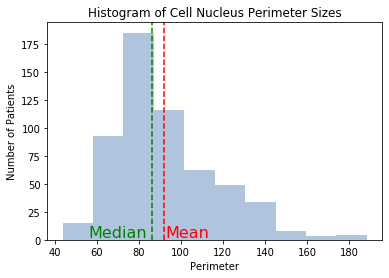

In [3]:
mean_color='red'
median_color='green'

plt.hist(perimeters, color='lightsteelblue')
plt.axvline(perm_mean, color=mean_color, linestyle='dashed')
plt.axvline(perm_median, color=median_color, linestyle='dashed')

plt.text(perm_mean*1.01, 2, 'Mean', fontsize=16, color=mean_color)
plt.text(perm_median*0.65, 2, 'Median', fontsize=16, color=median_color)
plt.title('Histogram of Cell Nucleus Perimeter Sizes')
plt.xlabel('Perimeter')
plt.ylabel('Number of Patients')

plt.show()

# Part B

*Is the first feature in this data set (the “radius”) normally distributed? Quantify your answer. If not, what might be a more appropriate distribution?*

To start answering this, let's first go ahead and just look at the distribution of the radius in a histogram and plot a normal curve over it that has the same mean and standard deviation.

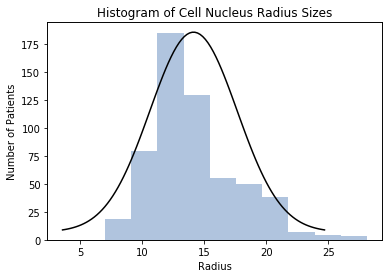

In [4]:
radius_idx = 0 # Again, the updated index after removing id and diagnosis
radii = features[:,radius_idx]

# Create our histogram
fig,ax = plt.subplots()
ax.hist(radii, color='lightsteelblue')
plt.title('Histogram of Cell Nucleus Radius Sizes')
plt.xlabel('Radius')
plt.ylabel('Number of Patients')

# Create data for a normal curve and add it to the plot
radii_mean = np.mean(radii)
radii_std = np.std(radii)
normal_x = np.linspace(radii_mean - 3*radii_std, radii_mean + 3*radii_std, num=100)
normal_y = stats.norm.pdf(normal_x, radii_mean, radii_std)

ax2 = ax.twinx()
ax2.set_yticks([])
plt.plot(normal_x, normal_y, color='black')

plt.show()

That visually looks like it's skewed to the left, but let's do a statistical test to see how likely a sample with this distribution is to have been drawn from a normal distribution. 

We can run SciPy's built-in *normaltest* to test the null hypothesis that our *radii* sample comes from a normal distribution. In order to do this, we need to select a threshold for which we will reject the hypothesis if the p-value is less than it. Let's set our threshold at 0.05.

In [5]:
threshold = 0.05
s2k2, p = stats.normaltest(radii)

print('P-value:',p)
if(p < threshold):
    print('''\nReject the null hypothesis. \nThe sample is unlikely to have come from a normal distribution.''')
else:
    print('''\nAccept the null hypothesis. \nThe sample is likely to have come from a normal distribution.''')

P-value: 1.286172249506454e-16

Reject the null hypothesis. 
The sample is unlikely to have come from a normal distribution.


The test backs up our visual assesment. A normal distribution wouldn't be the best representation for this data. This looks it could be better represented by a Gamma distribution.

# Part C
*Train a classifier to predict the diagnosis of malignant or benign. Compare the results of two classifiers e.g. SVM, logistic regression, decision tree etc.*

First we need to transform our diagnosis vector into binary to make it easier to work with existing libraries. We'll say M=1 and B=0.

Then, we'll divide the data into a training and test set with about 70% of the data in the training set and 30% in the test set. 

Since it looks like the data is fairly random, we'll just divide it 70% of the way through. There are alternative apoproaches to dividing the training and testing data that could ensure we have balanced datasets or that would further randomize their distribution, but let's stick with something easy to start with.

In [7]:
# Transform diagnosis data
binary_diagnosis =  [1 if x=='M' else 0 for x in diagnoses]
# Divide into training and test sets
n_training = round(len(features)*0.7)
x_train = features[:n_training,:]
x_test = features[n_training:,:]
y_train = binary_diagnosis[:n_training]
y_test = binary_diagnosis[n_training:]

Since we're only going to evaluate two models, this probably isn't necessary, but let's try to minimize our repeated code by making a quick function that can evaluate a model and return relevant results to us. And also one to print them out.

In [8]:
def evaluate_model(model, x_test, y_test):
    y_pred = model.predict(x_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    return (accuracy, precision, recall)

def print_model_evaluation(results, model_name):
    print(model_name)
    print('Accuracy:', results[0])
    print('Precision:', results[1])
    print('Recall:', results[2],'\n')

Now let's train a couple models and see their results. We'll do a KNN, basic SVN, and a decision tree. And we'll look at the accuracy, precision, and recall for each classifier.

In [9]:
# KNN
knn_model = KNeighborsClassifier()
knn_model.fit(x_train, y_train)
knn_results = evaluate_model(knn_model, x_test, y_test)
print_model_evaluation(knn_results, 'KNN')

# SVM
svm_model = SVC(kernel='linear')
svm_model.fit(x_train, y_train)
svm_results = evaluate_model(svm_model, x_test, y_test)
print_model_evaluation(svm_results, 'SVM')

# Decision Tree
dt_model = DecisionTreeClassifier()
dt_model.fit(x_train, y_train)
dt_results = evaluate_model(dt_model, x_test, y_test)
print_model_evaluation(dt_results, 'DECISION TREE')

KNN
Accuracy: 0.935672514619883
Precision: 0.8043478260869565
Recall: 0.9487179487179487 

SVM
Accuracy: 0.9473684210526315
Precision: 0.8125
Recall: 1.0 

DECISION TREE
Accuracy: 0.8596491228070176
Precision: 0.6229508196721312
Recall: 0.9743589743589743 



The linear SVM is the clear frontrunner here as it has the highest score across all three metrics. With a recall of 1.0, it had no false negatives. Since we set *benign* to 0 in our data, this means that no instances of *malignant* cells were misclassified as being *benign*. For identifying cancer sells, this seems like the most important metric as we don't want to miss any malignant tumors. A precision score of 0.81 in the SVM says that almost one in five of the *malignant* classifications was incorrect. This will likely cause undue worry, but again is better than missing a cancerous tumor, and is much better than the decision tree classifier where only 65% of the supposed malignant diagnoses is correct. Further iteration on the SVM, such as trying a different kernel might result in better precision and accuracy.